Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0054 - val_loss: 0.0016
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 2.0942e-04 - val_loss: 9.8477e-04
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 2.2362e-04 - val_loss: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.0057e-04 - val_loss: 0.0012
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 2.3160e-04 - val_loss: 0.0015
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 2.0297e-04 - val_loss: 0.0011
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.6472e-04 - val_loss: 6.7353e-04
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.3941e-04 - val_loss: 9.1767e-04
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 1.5271e-04 - val_loss: 5.0268e-04
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.6882e-04 - val_loss: 4.3595e-04
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.0614e-04 - val_loss

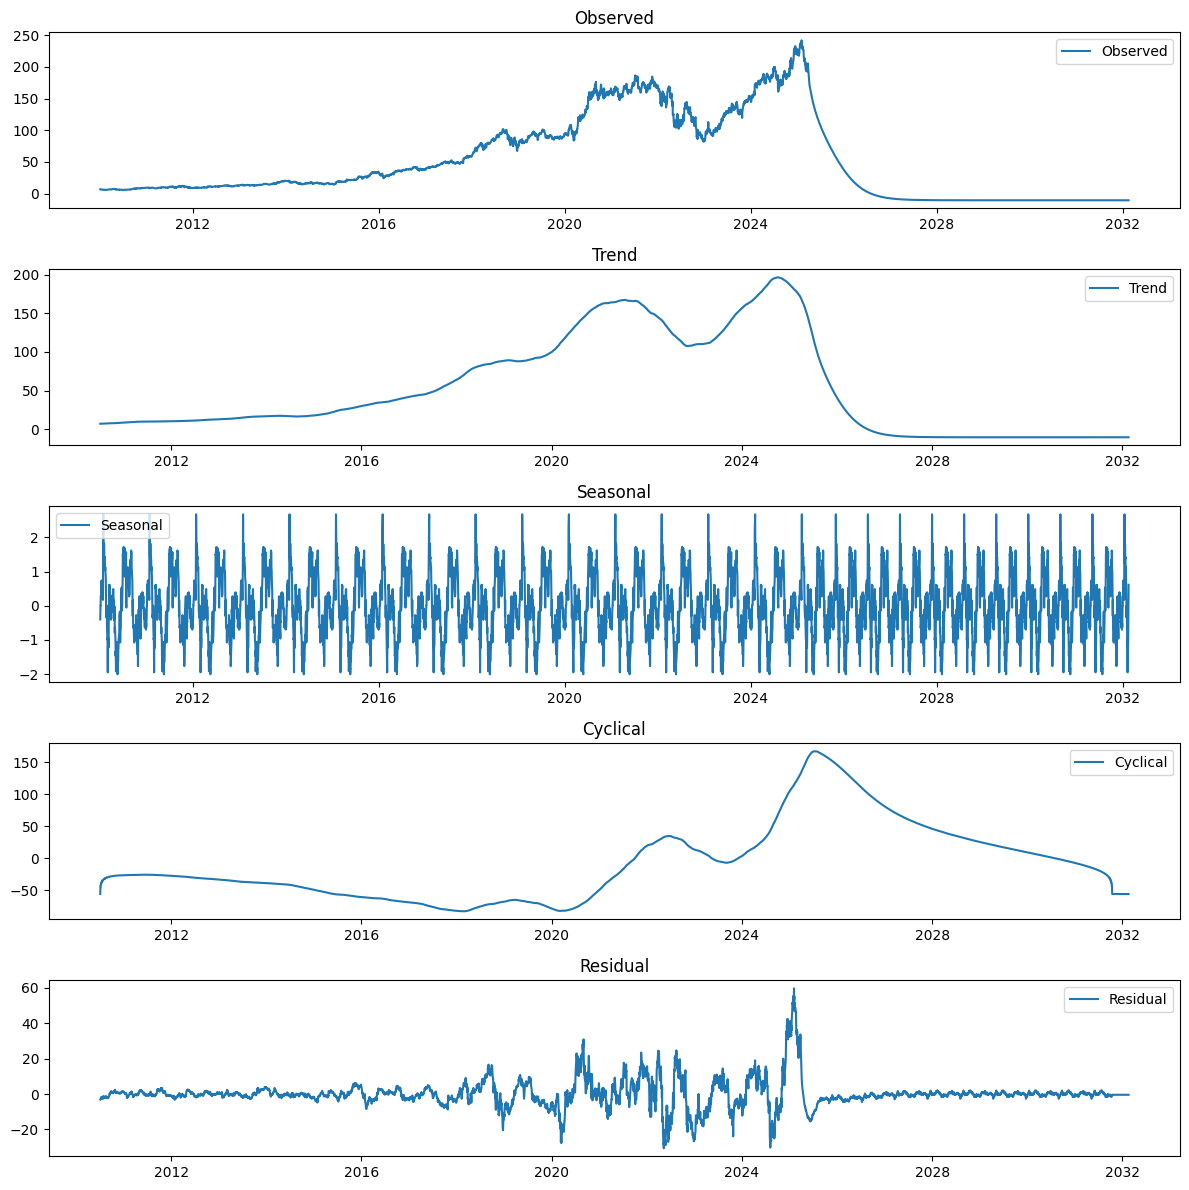

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import hilbert

# Mount Google Drive (if working on Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define file path in Google Drive
drive_path = "/content/drive/My Drive/TimeSeries/historical_data.csv"

# Load dataset
df = pd.read_csv(drive_path, parse_dates=['Date'], index_col='Date')

# Ensure the data is sorted by date
df = df.sort_index()

# Select the 'Close' column
data = df[['Close']].copy()

# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20  # Number of previous days to use for prediction
X, y = create_sequences(data_scaled, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)

# Predict future values (next 10 years)
forecast_steps = 10 * 252  # Assuming 252 trading days in a year
predictions = []

# Use the last seq_length data to start the prediction process
input_seq = data_scaled[-seq_length:].reshape(1, seq_length, 1)

for _ in range(forecast_steps):
    pred = model.predict(input_seq)
    predictions.append(pred[0, 0])
    input_seq = np.append(input_seq[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

# Inverse scale the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Generate future dates
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, forecast_steps + 1)]

# Create a new DataFrame for the predicted data
predicted_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

# Combine actual and predicted data
full_data = pd.concat([data, predicted_df])

# Decompose the time series
decomposed = seasonal_decompose(full_data, model='additive', period=252)  # Assuming yearly seasonality

# Compute Cyclical Component using Hilbert Transform
cyclical = np.imag(hilbert(decomposed.trend.dropna().values))
cyclical_series = pd.Series(cyclical, index=decomposed.trend.dropna().index)

# Align components with full_data index to prevent shape mismatch
aligned_trend = decomposed.trend.reindex(full_data.index)
aligned_seasonal = decomposed.seasonal.reindex(full_data.index)
aligned_residual = decomposed.resid.reindex(full_data.index)

# Align cyclical component
aligned_cyclical = pd.Series(cyclical, index=decomposed.trend.dropna().index).reindex(full_data.index)

# Ensure consistent index
decomposed_series = [
    full_data['Close'],  # Observed
    aligned_trend,
    aligned_seasonal,
    aligned_cyclical,
    aligned_residual
]
# Plot the decomposed components
fig, axes = plt.subplots(5, 1, figsize=(12, 12))

components = ['Observed', 'Trend', 'Seasonal', 'Cyclical', 'Residual']
decomposed_series = [decomposed.observed, decomposed.trend, decomposed.seasonal, cyclical_series, decomposed.resid]

for i, component in enumerate(decomposed_series):
    axes[i].plot(full_data.index, component, label=components[i])
    axes[i].set_title(components[i])
    axes[i].legend()

plt.tight_layout()
plt.show()
